# 테스트 (Carseats.csv)

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import cross_val_score
%matplotlib inline

In [23]:
path = '../data/Carseats.csv'

In [24]:
Carseats = pd.read_csv(path)
Carseats.head()

,Unnamed: 0,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,1,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,2,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,3,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,4,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,5,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [25]:
del Carseats["Unnamed: 0"]
print(Carseats.shape)
Carseats.head()

(400, 11)


,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


## Step 1
- Sales의 값이 8이하 0, 8초과 1로 설정
- Urban에서 No 0, Yes 1
- US에서 No 0, Yes 1
- 15개 leaf
(encoding 작업과 비슷)

In [26]:
Carseats['High'] = Carseats['Sales'].apply(lambda x: 0 if x <= 8 else 1)

In [27]:
# 3. class를 갖는 'ShelveLoc' 을 간단히 'factorize'함수로 변환
Carseats['ShelveLoc'] = pd.factorize(Carseats["ShelveLoc"])[0]

In [28]:
Carseats['Urban'] = Carseats['Urban'].apply(lambda x: 0 if x == 'No' else 1)
Carseats['US'] = Carseats['US'].apply(lambda x: 0 if x == 'No' else 1)

In [29]:
Carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,9.50,138,73,11,276,120,0,42,17,1,1,1
1,11.22,111,48,16,260,83,1,65,10,1,1,1
2,10.06,113,35,10,269,80,2,59,12,1,1,1
3,7.40,117,100,4,466,97,2,55,14,1,1,0
4,4.15,141,64,3,340,128,0,38,13,1,0,0


## DecisionTreeClassifier

In [30]:
X = Carseats.drop(['Sales','High'], axis=1)
y = Carseats["High"]

# 15개 잎으로 제한
# 범주화 되어있는 데이터들에 대해서 Classifier 적용
clf_tree = tree.DecisionTreeClassifier(max_leaf_nodes=15)
clf_tree.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=15,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [31]:
clf_tree.tree_.threshold

array([ 92.5,   0.5,   6.5, 144.5,   0.5,  -2. ,   1.5, 163.5, 124.5,
       121.5,  22. , 102.5,  -2. ,  -2. , 151.5,  58. ,  -2. ,  -2. ,
        -2. ,   0.5,  -2. ,  -2. ,  -2. ,  -2. ,  -2. ,  -2. ,  -2. ,
        -2. ,  -2. ])

In [32]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin'

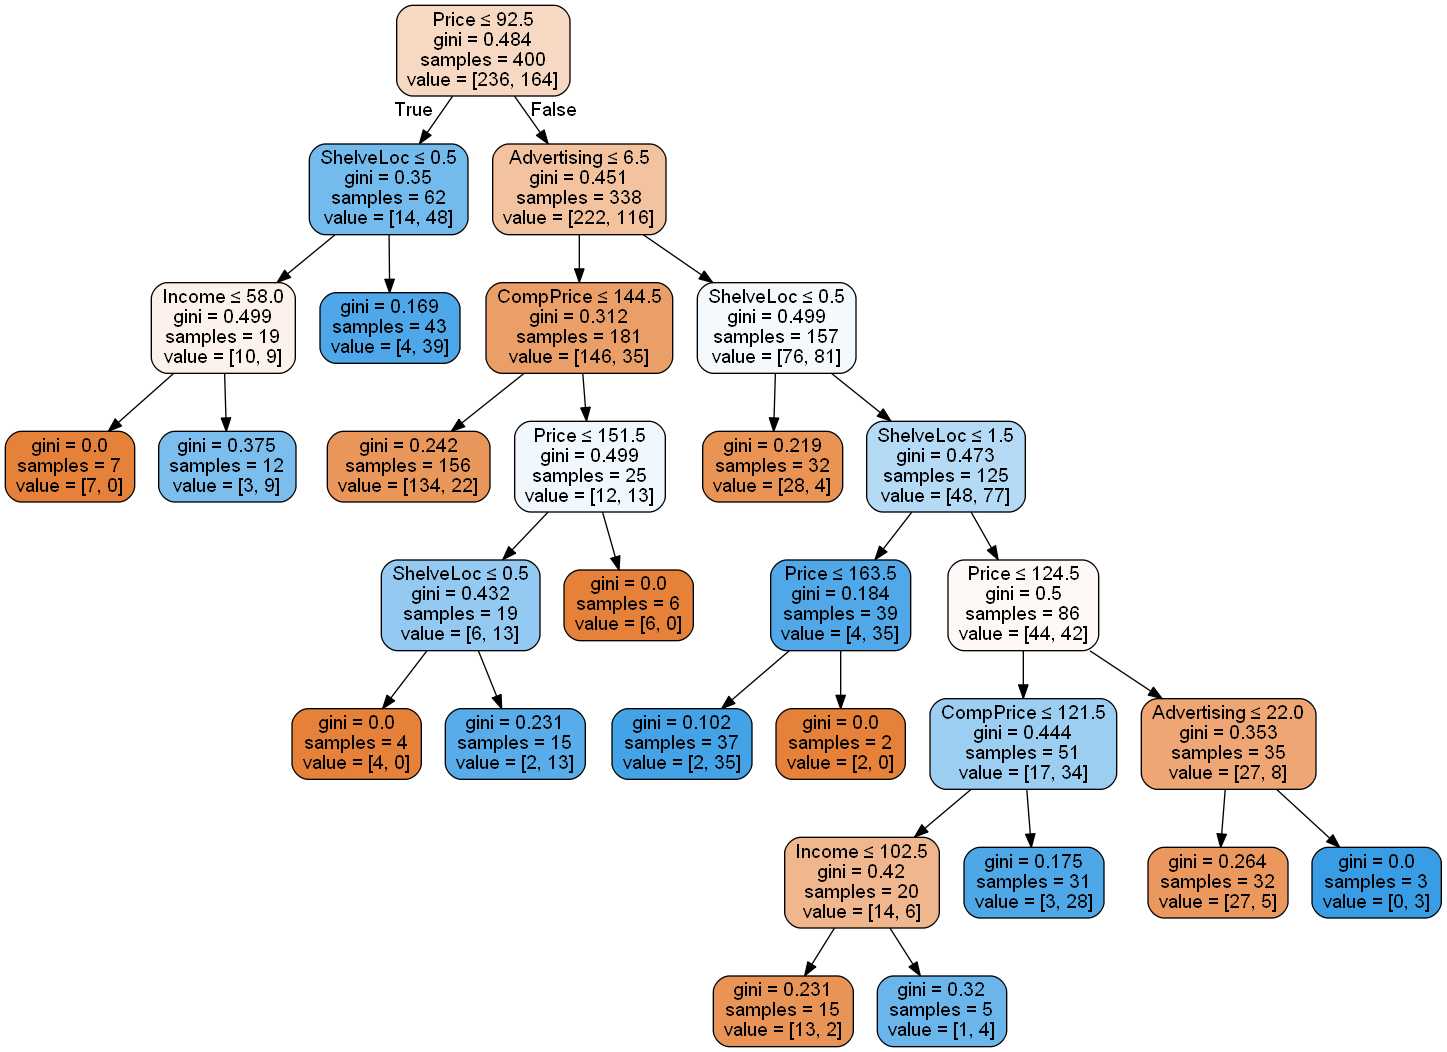

In [33]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

# 학습한 모델의 input으로 들어간 columns들을 가져옴
export_graphviz(clf_tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
               feature_names=X.columns)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [35]:
# 전에 했던 것처럼 4개 영역으로 나눈다. (train 문제지, 정답지 / test 문제지, 정답지)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1234)
clf_tree = tree.DecisionTreeClassifier(max_leaf_nodes = 15)

clf_tree.fit(X_train, y_train)

y_pred = clf_tree.predict(X_test)

accuracy_score(y_test,y_pred)

0.775

## Step3
최적의 잎 갯수 찾기: cv이용해서

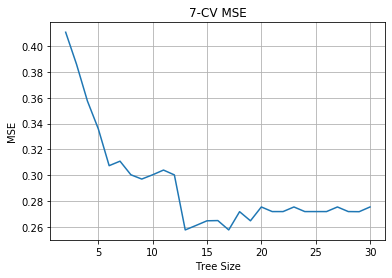

In [38]:
tree_sizes = range(2, 31)
MSE_scores = []
# 7로 , 7-fold
for size in tree_sizes:
    clf_tree = tree.DecisionTreeClassifier(max_leaf_nodes=size, random_state=1234)
    # 1 - 정확도 : 오차율 측정
    MSE_s = 1-cross_val_score(clf_tree, X_train, y_train, cv =7, scoring='accuracy')
    MSE_scores.append(np.mean(MSE_s))
    
    # plot CV-MSE as tree size gets bigger
plt.plot(tree_sizes, MSE_scores)
plt.title("7-CV MSE")
plt.xlabel("Tree Size")
plt.ylabel("MSE")
plt.grid(True)

# 앙상블 방법: Ensemble Method

- 기본 개념 : 단일한 모델을 사용해서 결과를 얻고자 하는 것이 아니라 여러가지 모델을 생성하고, 이들을 종합적으로 활용해서 판단을 하

## Bagging

- Bagging : Bootstrap Aggregation  
학습데이터에 대해서 Sampling을 한다는 것이고 이것은 최대한 Random 하게 해야 한다. 중요한 것은 전체 데이터에 대해서 일부분들을 Random하게 추출하는 Sampling이다. 그리고 이러한 것을 바탕으로 각기 샘플된 데이터를 기반으로 분류기를 학습한다.  
  
Decision Tree하나를 여러번 돌리는 것이라 생각 (또는 knn 등 다른 모델 하나로)  
알고리즘을 여러개 사용할 수 있고, 동일한 데이터를 여러번 Sampling해서 하나의 모델로 돌릴 수도 있다.

## Voting Ensemble
- http://mlwave.com/kaggle-ensembling-guide/
- (상황) 우선 분류를 하는 학습기 A, B, C가 존재하고, 이들은 각기 70%의 정확도를 보이고 있다.  
이러한 상황에서 이들을 모두 사용해서 다수결 법칙으로 결정하고자 한다면?

In [39]:
case1 = 0.7*0.7*0.7
print(case1)

0.3429999999999999


3개 모델 중에 2개 이상 맞추면 된다.

In [40]:
case2 = 3 * 0.7 * 0.7 * 0.3
print(case1 + case2)

0.7839999999999998


단순히 70%인 하나의 모델을 사용하기 보다 3개를 같이 돌리는 것이 좋다.  
하나의 모델이 틀릴 수 있는 경우를 다른 모델이 커버를 해준다.

## Random Forest
- feature 수 (max_features), minimum sample개수

In [41]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [68]:
# 앞에서 사용한 one-hot-encoding 데이터 사용
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

# tree 500개를 split할 때 6개 feature 중에서 선택
RF_cif = RandomForestClassifier(n_estimators=500, max_features=6, random_state=1234)

# Training set으로 RF regressor 학습
RF_cif.fit(X_train, y_train)

# Test with Test Set
y_pred = RF_cif.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.8833333333333333


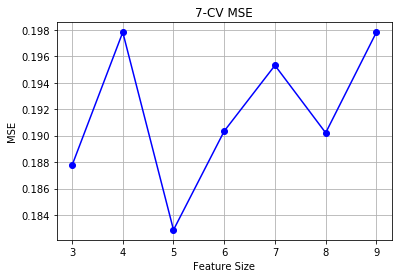

In [69]:
feature_sizes = range(3, 10)
MSE_scores = []

# 7-fold CV for each tree
for size in feature_sizes:
    RF_cif = RandomForestClassifier(n_estimators=500, max_features=size, random_state=1234)
    MSEn_s = 1-cross_val_score(RF_cif, X, y, cv =7, scoring='accuracy', n_jobs=-1)
    MSE_scores.append(np.mean(MSE_s))
    
    # plot CV-MSE as tree size gets bigger
plt.plot(feature_sizes, MSE_scores, 'bo-')
plt.title("7-CV MSE")
plt.xlabel("Feature Size")
plt.ylabel("MSE")
plt.grid(True)

### 5개 일때 가장 낮은 것을 확인

In [70]:
# 최적화 했는데 오히려 떨어지는 경우가 있다.
RF_cif = RandomForestClassifier(n_estimators=500, max_features=5, random_state=1234)

RF_cif.fit(X_train, y_train)

y_pred = RF_cif.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.875


In [71]:
X.columns

Index(['CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')

In [72]:
RF_cif.feature_importances_

array([0.11657144, 0.11008429, 0.12574664, 0.07650895, 0.208217  ,
       0.14033199, 0.14483086, 0.05167041, 0.01262903, 0.0134094 ])

In [73]:
Importance=pd.DataFrame({'feature':X.columns, 'importance':RF_cif.feature_importances_}).sort_values(by='importance', ascending=False)
Importance

,feature,importance
4,Price,0.208217
6,Age,0.144831
5,ShelveLoc,0.140332
2,Advertising,0.125747
0,CompPrice,0.116571
1,Income,0.110084
3,Population,0.076509
7,Education,0.051670
9,US,0.013409
8,Urban,0.012629
